In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 150)

df = pd.read_csv('./in/plays_with_passer_expanded_with_z_norm.csv', low_memory=False)
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,pass_forward_frame,ball_snap_frame,play_direction,frames_to_pass,seconds_since_pass,los_norm,start_x_norm,end_x_norm,start_y_norm,end_y_norm
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,36,11,left,25,2.5,40,33.10,46.71,26.33,6.83
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,31,11,left,20,2.0,40,34.39,43.69,23.62,16.91
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,34,11,left,23,2.3,40,34.49,37.41,24.64,47.49
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,39,11,left,28,2.8,40,30.60,61.83,26.24,41.47
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,31,11,left,20,2.0,40,33.52,41.95,28.86,10.88


In [2]:
df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'passer', 'v', 'vxy', 'vz', 'launch_angle', 'air_time', 'z_max',
       'distance', 'start_x', 'start_y', 'end_x', 'end_y',
       'pass_arrived_frame', 'pass_forward_frame', 'ball_snap_frame',
       'play_direction', 'frames_to_pass', 'seconds_since_pass', 'los_norm',
       'start_x_norm', 'end_x_norm', 'start_y_norm', 'end_y_norm'],
      dtype='object')

In [3]:
df['air_x_yards'] = np.abs(df.end_x-df.start_x)
df['T_frames'] = df.pass_arrived_frame-df.pass_forward_frame
df['throw_dx'] = df.end_x_norm-df.start_x_norm
df['throw_dy'] = df.end_y_norm-df.start_y_norm
df['throw_dist'] = np.sqrt(df.throw_dx**2+df.throw_dy**2)
df = df.loc[(df.T_frames>0) & (df.distance>0)]
# df = df.dropna()

# P(t) section

In [4]:
df.frames_to_pass.quantile([0.005, 0.01, 0.05, 0.1, 0.9, 0.95, 0.99, 0.995])

0.005     8.0
0.010    10.0
0.050    14.0
0.100    17.0
0.900    39.0
0.950    47.0
0.990    63.0
0.995    71.0
Name: frames_to_pass, dtype: float64

In [5]:
# consider most passes by t
frame_min = 1
frame_max = 100
filt_df = df.loc[(df.frames_to_pass>=frame_min)&(df.frames_to_pass<=frame_max)]

8.10119275377934 3.381934123477982


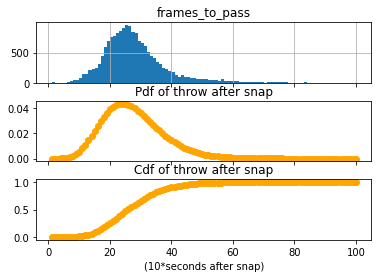

0.9999992497826607


In [6]:
# P(t)
import scipy.stats as stats
fig, axs = plt.subplots(3, sharex=True)
filt_df.hist(column='frames_to_pass', bins=list(1*x for x in range(frame_min, frame_max+1)), ax=axs[0])

fit_alpha, fit_loc, fit_theta = stats.gamma.fit(filt_df.frames_to_pass.to_numpy(), floc=0)
print(fit_alpha, fit_theta)
x = np.linspace(frame_min, frame_max, 1+frame_max-frame_min)
y = stats.gamma.pdf(x, a=fit_alpha, loc=fit_loc, scale=fit_theta)
axs[1].scatter(x, y, color='orange')
axs[1].set_title('Pdf of throw after snap')

y2 = np.cumsum(y)
axs[2].scatter(x, y2, color='orange')
axs[2].set_title('Cdf of throw after snap')
axs[2].set_xlabel('(10*seconds after snap)')
plt.show()

print(y.sum())

In [7]:
p_t_df = pd.DataFrame({'frame_to_pass': x, 'p': y})
p_t_df.head()

,frame_to_pass,p
0,1.0,6.214520e-09
1,2.0,6.348390e-07
2,3.0,8.408249e-06
3,4.0,4.825070e-05
4,5.0,1.750912e-04


In [9]:
p_t_df.to_csv('./in/p_t.csv', index=False)
p_t_df.to_pickle('./in/p_t.pkl')

# P(T|L) section

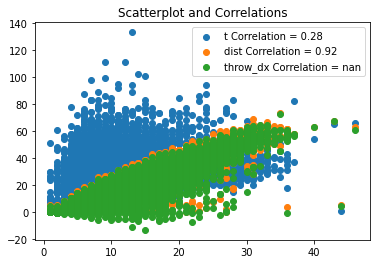

In [10]:
x = df.T_frames.to_numpy()
y1 = df.frames_to_pass.to_numpy()
y2 = df.distance.to_numpy()
y3 = df.throw_dx.to_numpy()
plt.scatter(x, y1, label=f't Correlation = {np.round(np.corrcoef(x,y1)[0,1], 2)}')
plt.scatter(x, y2, label=f'dist Correlation = {np.round(np.corrcoef(x,y2)[0,1], 2)}')
plt.scatter(x, y3, label=f'throw_dx Correlation = {np.round(np.corrcoef(x,y3)[0,1], 2)}')

# Plot
plt.title('Scatterplot and Correlations')
plt.legend()
plt.show()

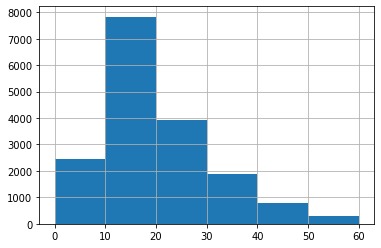

In [11]:
dist_bin = 10
dist_min, dist_max = 0, 60
dist_bins = [b for b in range(dist_min, dist_max+1, dist_bin)]
df.throw_dist.hist(bins=dist_bins)

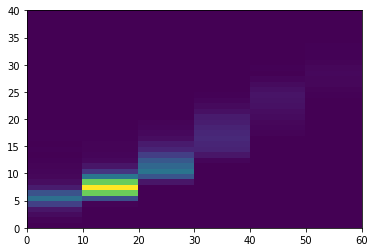

In [12]:
T_bin = 1
T_min, T_max = 0, 40
T_bins = [b for b in range(T_min, T_max+1, T_bin)]
_, _, _, _ = plt.hist2d(df.throw_dist, df.T_frames, [dist_bins, T_bins])

In [13]:
df['dist_bin'] = pd.cut(df.throw_dist, bins=dist_bins,)
df.groupby('dist_bin').playId.count()

dist_bin
(0, 10]     2455
(10, 20]    7830
(20, 30]    3940
(30, 40]    1889
(40, 50]     778
(50, 60]     284
Name: playId, dtype: int64

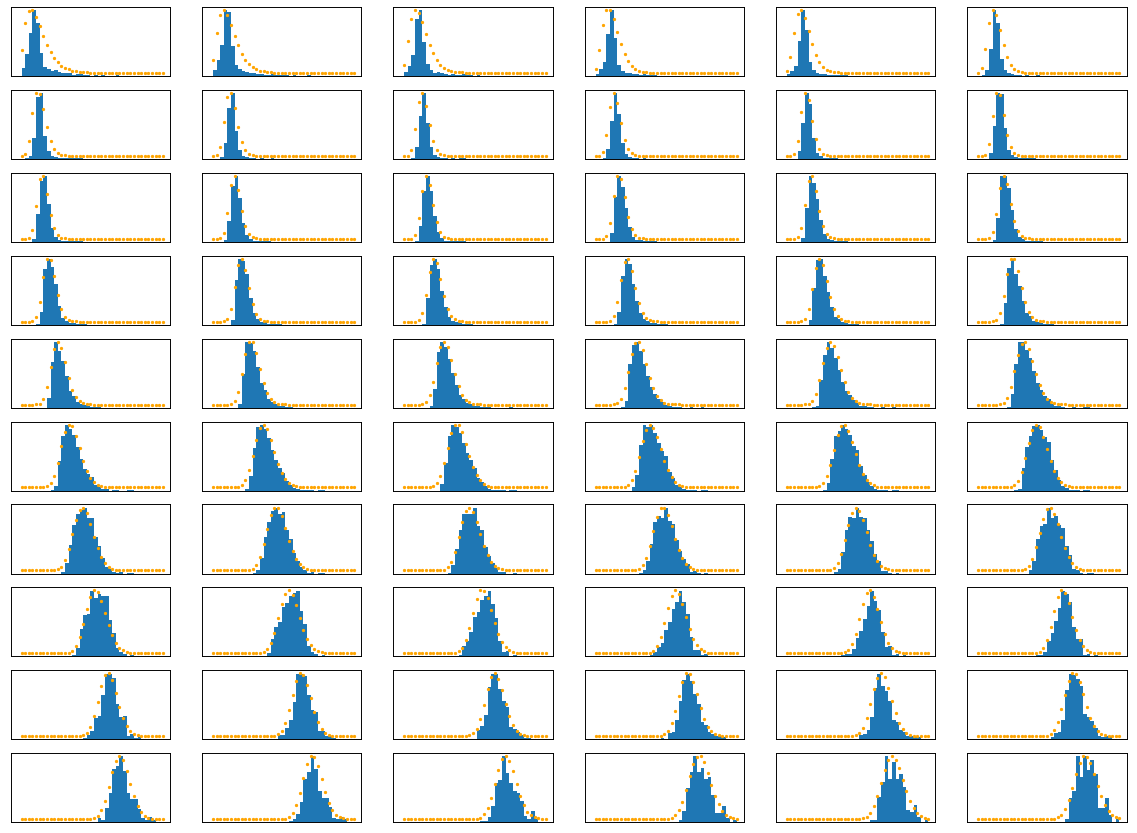

In [14]:
T_given_L = pd.DataFrame()
window_half = 5
fig, axs = plt.subplots(10,6, sharex=True, figsize=(20,15))
# print(len(axs), len(axs[0]))
for d in range(1, 61, 1):
    T_wind = df.loc[(df.distance >= d-window_half)&(df.distance <= d+window_half)]    
    
    ax1 = axs[(d-1)//6][(d-1)%6]
    T_wind.T_frames.hist(bins=list(1*x for x in range(0, 41)), ax=ax1, density=True)
    ax2 = ax1.twinx()
    x = np.linspace(1, 40, 40)
    alpha, loc, theta = stats.gamma.fit(T_wind.T_frames.to_numpy(), floc=0)
    y1 = stats.gamma.pdf(x, a=alpha, loc=loc, scale=theta)
#     T_given_t.append(y1)
    ax2.scatter(x, y1, color='orange', marker=".", s=20)
    # ax2.set_title(str(np.array([alpha, theta]).round(2)))
    # ax2.set_xlabel('T_frames')
    ax2.grid(False)
    ax1.grid(False)
    ax2.get_xaxis().set_ticks([])
    ax1.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    # fig.suptitle(f'{d}')
    # plt.show()
    
    tmp = pd.DataFrame()
    tmp['T'] = x
    tmp['p'] = y1
    tmp['dist'] = d
#     tmp['dist'] = df.dist_bin.iloc[0]
    T_given_L = T_given_L.append(tmp)
fig.show()

In [15]:
T_given_L.reset_index(drop=True).rename(columns={'dist': 'pass_dist', 'T':'pass_air_frames', 'p': 'p'})[['pass_dist', 'pass_air_frames', 'p']]

,pass_dist,pass_air_frames,p
0,1,1.0,0.053500
1,1,2.0,0.114228
2,1,3.0,0.143292
3,1,4.0,0.144579
4,1,5.0,0.129472
...,...,...,...
2395,60,36.0,0.029416
2396,60,37.0,0.017002
2397,60,38.0,0.009131
2398,60,39.0,0.004573


In [16]:
T_given_L.to_csv('./in/T_given_L.csv', index=False)
T_given_L.to_pickle('./in/T_given_L.pkl')

# P(L | t)

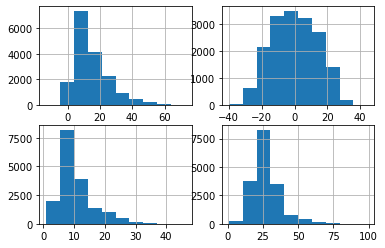

In [17]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
filt_df.throw_dx.hist(ax=ax1)
filt_df.throw_dy.hist(ax=ax2)
filt_df.T_frames.hist(ax=ax3)
filt_df.frames_to_pass.hist(ax=ax4)

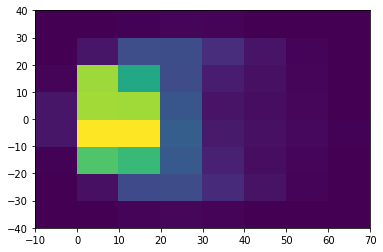

In [18]:
x_bin = 10
y_bin = 10

passes_in_bin = x_bin*y_bin
x_min, x_max = -10, 70
y_min, y_max = -40, 40

x_bins = [b for b in range(x_min, x_max+1, x_bin)]
y_bins = [b for b in range(y_min, y_max+1, y_bin)]

dist, _, _, _ = plt.hist2d(filt_df.throw_dx, filt_df.throw_dy, [x_bins, y_bins])

In [19]:
df['dx_bin'] = pd.cut(df.throw_dx, bins=x_bins,)
df['dy_bin'] = pd.cut(df.throw_dy, bins=y_bins,)

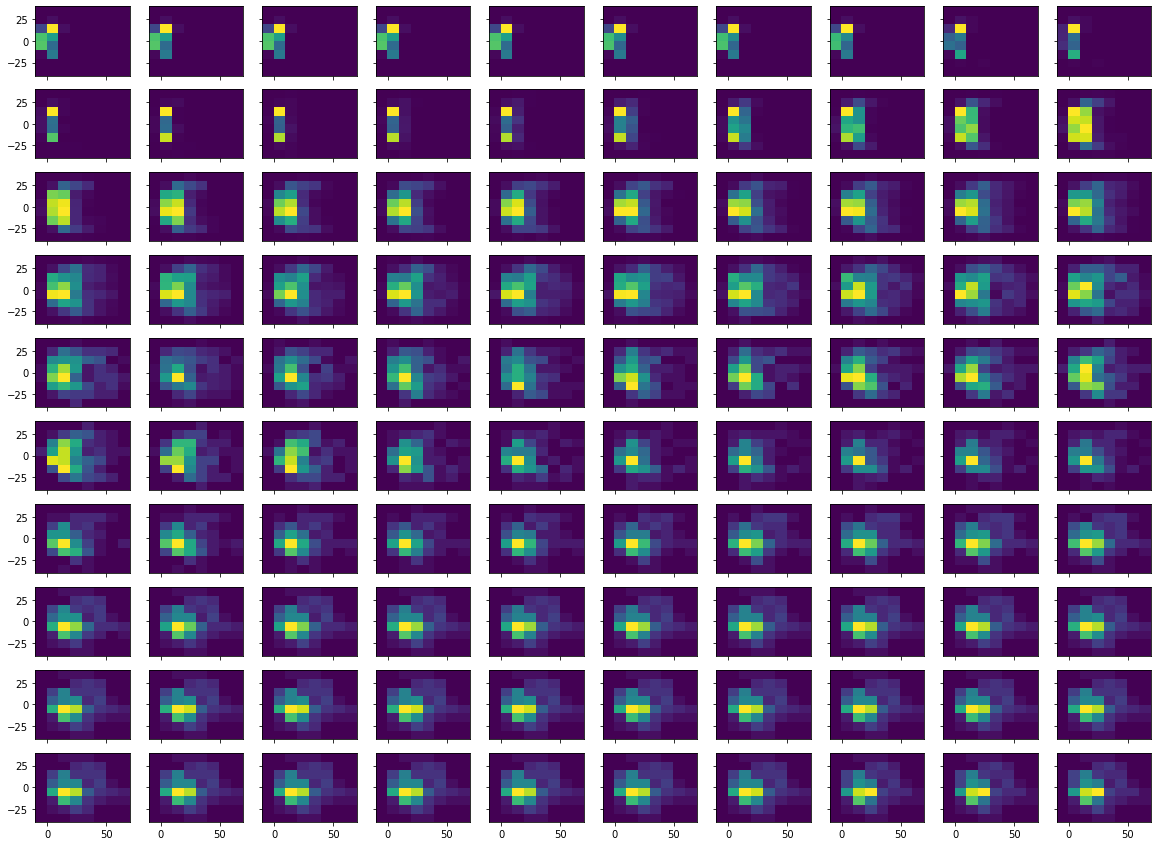

In [20]:
# P(L|t)
min_window_half = 1
L_given_t_df = pd.DataFrame()
fig, axs = plt.subplots(10,10, sharex=True, sharey=True, figsize=(20,15))

for t in range(frame_min,frame_max+1):
    currWind = min_window_half
    t_wind = df.loc[(df.frames_to_pass >= t-currWind)&(df.frames_to_pass <= t+currWind)]
    while (len(t_wind)<200):
        currWind += 1
        t_wind = t_wind.append(df.loc[(df.frames_to_pass == t-currWind)|(df.frames_to_pass == t+currWind)]) # not using filt_df because want to consider values outside filt_df but in window on edges
        
    # air_frame_window = filt_df.loc[filt_df.frames_to_pass==t]
    ax = axs[(t-1)//10][(t-1)%10]
    ax.hist2d(t_wind.throw_dx, t_wind.throw_dy, [x_bins, y_bins])
    # ax.set_title(f'{t}, {currWind}, {len(t_wind)}')
    # plt.show()

    bin_vals = t_wind.groupby(['dx_bin', 'dy_bin'], as_index=False)[['playId']].count().rename(columns={'playId': 'cnt'}).fillna({'cnt': 0})
    bin_vals['bin_p'] = bin_vals.cnt/bin_vals.cnt.sum()
    bin_vals['pass_p'] = bin_vals.bin_p/passes_in_bin
    bin_vals['t'] = t

    L_given_t_df = L_given_t_df.append(bin_vals)
fig.show()

In [21]:
L_given_t_df = L_given_t_df.rename(columns={'t': 'frames_to_pass', 'dx_bin': 'pass_dx_bin', 'dy_bin': 'pass_dy_bin', 'cnt': 'bin_hist_cnt', 'pass_p': 'per_pass_p'})[['frames_to_pass', 'pass_dx_bin', 'pass_dy_bin', 'bin_hist_cnt', 'bin_p', 'per_pass_p']]
print(L_given_t_df.loc[(L_given_t_df.frames_to_pass==27)].bin_p.sum())
L_given_t_df.loc[(L_given_t_df.frames_to_pass==27)].sort_values('bin_p', ascending=False).head()

1.0


,frames_to_pass,pass_dx_bin,pass_dy_bin,bin_hist_cnt,bin_p,per_pass_p
11,27,"(0, 10]","(-10, 0]",317.0,0.121363,0.001214
19,27,"(10, 20]","(-10, 0]",291.0,0.111409,0.001114
12,27,"(0, 10]","(0, 10]",268.0,0.102603,0.001026
20,27,"(10, 20]","(0, 10]",260.0,0.099541,0.000995
21,27,"(10, 20]","(10, 20]",180.0,0.068913,0.000689


In [22]:
L_given_t_df.loc[(L_given_t_df.frames_to_pass==1)&(pd.IntervalIndex(L_given_t_df.pass_dy_bin).contains(-39))].sort_values('bin_p', ascending=False).head()

,frames_to_pass,pass_dx_bin,pass_dy_bin,bin_hist_cnt,bin_p,per_pass_p
0,1,"(-10, 0]","(-40, -30]",0.0,0.0,0.0
8,1,"(0, 10]","(-40, -30]",0.0,0.0,0.0
16,1,"(10, 20]","(-40, -30]",0.0,0.0,0.0
24,1,"(20, 30]","(-40, -30]",0.0,0.0,0.0
32,1,"(30, 40]","(-40, -30]",0.0,0.0,0.0


In [23]:
frame_min, frame_max = 1, 100
x_bin = 10
y_bin = 10

passes_in_bin = x_bin*y_bin
x_min, x_max = -9, 70
y_min, y_max = -39, 40

x_bins = [b for b in range(x_min, x_max+1, x_bin)]
y_bins = [b for b in range(y_min, y_max+1, y_bin)]

L_given_t_np = np.empty((frame_max+1-frame_min, y_max+1-y_min, x_max+1-x_min), dtype=np.float32)

for ti, tt in enumerate(range(frame_min, frame_max+1)):
    for yi, yy in enumerate(range(y_min, y_max+1, y_bin)):
        for xi, xx in enumerate(range(x_min, x_max+1, x_bin)):
            L_given_t_np[ti, yi, xi] = L_given_t_df.loc[(L_given_t_df.frames_to_pass==tt)&\
                                                        (pd.IntervalIndex(L_given_t_df.pass_dy_bin).contains(yy))&\
                                                        (pd.IntervalIndex(L_given_t_df.pass_dx_bin).contains(xx)), 'per_pass_p']
        
np.save('in/L_given_t.npy', L_given_t_np)

# output: ()

In [24]:
L_given_t_df.to_csv('./in/L_given_t.csv', index=False)
L_given_t_df.to_pickle('./in/L_given_t.pkl')

# P(T|t) (This is useless... less correlation than T|L)

In [ ]:
df.air_time.hist(bins=list(0.1*x for x in range(0, 40))) #air_frame has float binning issues... using integer frame values instead

In [ ]:
df.air_frames.hist(bins=list(1*x for x in range(0, 40)))

In [ ]:
# P(T|t)
window_half = 2
T_gamma_df = pd.DataFrame([], columns=['T_alpha', 'T_theta'])
# executive decision: only frames 10-63 are valid for our model
T_given_t = []
for t in range(frame_min,frame_max+1):
    fig, axs = plt.subplots(2, sharex=True)
    air_frame_window = df.loc[(df.frames_to_pass >= t-window_half)&(df.frames_to_pass <= t+window_half)][['air_frames']] # not using filt_df because want to consider values outside filt_df but in window on edges
    # air_frame_window = filt_df.loc[filt_df.frames_to_pass==t]
    air_frame_window.air_frames.hist(bins=list(1*x for x in range(0, 41)), ax=axs[0])

    x = np.linspace(1, 40, 40)
    alpha, loc, theta = stats.gamma.fit(air_frame_window.air_frames.to_numpy(), floc=0)
    y1 = stats.gamma.pdf(x, a=alpha, loc=loc, scale=theta)
    T_given_t.append(y1)
    axs[1].scatter(x, y1, color='orange')
    axs[1].set_title(str(np.array([alpha, theta]).round(2)))
    axs[1].set_xlabel('air_frames (T)')
    axs[1].grid(True)

    T_gamma_df = T_gamma_df.append(pd.DataFrame({'T_alpha': alpha, 'T_theta': theta}, index=[t+11]))
#     fig.suptitle(f't:{t}, samples; {len(air_frame_window)}')
#     plt.show()
T_given_t = np.stack(T_given_t)
print(T_given_t.shape)
np.save('T_given_ts.npy', T_given_t)    

In [ ]:
T_gamma_df.to_csv('T_given_ts.csv', index=True)

In [ ]:
T_gamma_df.rename_axis("t", inplace=True)
T_gamma_df.head() # use this for P(T|t)

In [ ]:
T_gamma_df.describe().round(2)

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, sharex=True)
ax1.scatter(T_gamma_df.index, T_gamma_df.T_alpha, label='alpha')
ax2.scatter(T_gamma_df.index, T_gamma_df.T_theta, label='theta', color='orange')
fig.legend()

In [ ]:
#GARBAGE BELOW THIS: IGNORE

In [ ]:
a, l, b = gamma_df.loc[69]
x = np.linspace(1, 40, 40)
y = stats.gamma.pdf(x, a=a, loc=l, scale=b)
plt.scatter(np.delete(x, 5), np.delete(y, 5), color='orange')
np.delete(y, 5).sum()

In [ ]:
st = df.groupby(['frames_to_pass']).air_frames.describe().reindex(list(range(1,121, 1)),fill_value=np.nan)
st.head(10)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(st.index, st['mean'], label='mean', s=st['count'])
ax1 = plt.scatter(st.index, st['std'], label='std', s=st['count'])
plt.legend(loc='upper left')
plt.show()

In [ ]:
st['w_mean'] = st['count']*st['mean']
st['w_std'] = st['count']*st['std']
st.head()

In [ ]:
bruh = st[['count', 'w_mean', 'w_std']].rolling(30, min_periods=0, center=True).sum()
bruh['r_w_mean'] = bruh.w_mean/bruh['count']
bruh['r_w_std'] = bruh.w_std/bruh['count']
print(len(bruh))
print(len(bruh.dropna()))

In [ ]:
final = bruh.loc[bruh.index <= 90]


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(bruh.index, bruh['r_w_mean'], label='mean')
ax1 = plt.scatter(bruh.index, bruh['r_w_std'], label='std')
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(final.index, final['r_w_mean'], label='mean')
ax1 = plt.scatter(final.index, final['r_w_std'], label='std')
plt.legend(loc='upper left')
plt.show()

In [ ]:
bruh.tail()

In [ ]:
final.tail()

In [ ]:
def sinc_interp(x, s, u):
    if len(x) != len(s):
        raise ValueError('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

interp_mean = sinc_interp(bruh['r_w_mean'], st.index, st.index)
interp_std = sinc_interp(bruh['r_w_std'], st.index, st.index)

print(st['mean'].size)
print(st['std'].size)
print(sma_mean.size)
print(sma_std.size)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(st.index, interp_mean, label='mean')
ax1 = plt.scatter(st.index, interp_std, label='std')
plt.legend(loc='upper left')
plt.show()


In [ ]:
def sinc_interp(x, s, u):
    if len(x) != len(s):
        raise ValueError('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

interp_mean = sinc_interp(sma_mean, st.index, st.index)
interp_std = sinc_interp(sma_std, st.index, st.index)

print(st['mean'].size)
print(st['std'].size)
print(sma_mean.size)
print(sma_std.size)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(st.index, interp_mean, label='mean')
ax1 = plt.scatter(st.index, interp_std, label='std')
plt.legend(loc='upper left')
plt.show()